# Text classification with Pytorch

Lab made by Mohamed Aymen Bouyahia and Melek Ghouma

The goal of this lab are to:
- Implement an 'handmade' model of text classification with word embeddings,
- Learn how to use Pytorch for treating textual data,
- Implementing neural classification models with Pytorch.

Besides ```torch```, we will use ```gensim``` to obain word embeddings, and ```scikit-learn``` for simple classification models.  

In [216]:
import os.path as op
import re
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

## I - Simple classifier on top of dense representations

### I.1 Dataset

We're going to work with the **20NewsGroup** data. This dataset is available in ```scikit-learn```, you can find all relevant information in the [documentation](https://scikit-learn.org/0.19/datasets/twenty_newsgroups.html).

In [217]:
from sklearn.datasets import fetch_20newsgroups

In [218]:
# Import training data
ng_train = fetch_20newsgroups(subset='train',
                              remove=('headers', 'footers', 'quotes')
                              )

In [219]:
# Let's look at what is in this object
pprint(dir(ng_train))

['DESCR', 'data', 'filenames', 'target', 'target_names']


In [220]:
# Let's look at the categories
pprint(ng_train.target_names)

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']


In [221]:
# .. and the data itself
pprint(ng_train.data[0])
print("Target: ", ng_train.target_names[ng_train.target[0]])

('I was wondering if anyone out there could enlighten me on this car I saw\n'
 'the other day. It was a 2-door sports car, looked to be from the late 60s/\n'
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition,\n'
 'the front bumper was separate from the rest of the body. This is \n'
 'all I know. If anyone can tellme a model name, engine specs, years\n'
 'of production, where this car is made, history, or whatever info you\n'
 'have on this funky looking car, please e-mail.')
Target:  rec.autos


The dataset can be rather difficult as it is; especially, some categories are very close to each other. We can simplify the task by using the higher-level categorisation of the newsgroups, thanks to the following function:

In [222]:
def aggregate_labels(label):
    # comp
    if label in [1,2,3,4,5]:
        new_label = 0
    # rec
    if label in [7,8,9,10]:
        new_label = 1
    # sci
    if label in [11,12,13,14]:
        new_label = 2
    # misc
    if label in [6]:
        new_label = 3
    # pol
    if label in [16,17,18]:
        new_label = 4
    # rel
    if label in [0,15,19]:
        new_label = 5
    return new_label

We will first need to apply some pre-processing. Choose your tokenizer and the processing you estimate appropriate. Careful, the data is not always clean and the messages are sometimes short: hence, applying pre-processing and tokenization can easily return an empty list of words. **Be careful to remove documents that are empty !**
<div class='alert alert-block alert-info'>
            Code:</div>

In [223]:
from nltk import word_tokenize

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [224]:
# Pre-processing
ng_train_text = []
ng_train_labels = []
for i in range(len(ng_train.data)):
    text = ng_train.data[i]
    label = ng_train.target[i]
    tokens = word_tokenize(text)
    if len(tokens) > 0:
        ng_train_text.append(tokens)
        ng_train_labels.append(aggregate_labels(label))

In [225]:
ng_train_text

[['I',
  'was',
  'wondering',
  'if',
  'anyone',
  'out',
  'there',
  'could',
  'enlighten',
  'me',
  'on',
  'this',
  'car',
  'I',
  'saw',
  'the',
  'other',
  'day',
  '.',
  'It',
  'was',
  'a',
  '2-door',
  'sports',
  'car',
  ',',
  'looked',
  'to',
  'be',
  'from',
  'the',
  'late',
  '60s/',
  'early',
  '70s',
  '.',
  'It',
  'was',
  'called',
  'a',
  'Bricklin',
  '.',
  'The',
  'doors',
  'were',
  'really',
  'small',
  '.',
  'In',
  'addition',
  ',',
  'the',
  'front',
  'bumper',
  'was',
  'separate',
  'from',
  'the',
  'rest',
  'of',
  'the',
  'body',
  '.',
  'This',
  'is',
  'all',
  'I',
  'know',
  '.',
  'If',
  'anyone',
  'can',
  'tellme',
  'a',
  'model',
  'name',
  ',',
  'engine',
  'specs',
  ',',
  'years',
  'of',
  'production',
  ',',
  'where',
  'this',
  'car',
  'is',
  'made',
  ',',
  'history',
  ',',
  'or',
  'whatever',
  'info',
  'you',
  'have',
  'on',
  'this',
  'funky',
  'looking',
  'car',
  ',',
  'please',

In [226]:
ng_train_labels

[1,
 0,
 0,
 0,
 2,
 4,
 2,
 0,
 0,
 0,
 1,
 5,
 0,
 2,
 3,
 5,
 0,
 1,
 2,
 0,
 5,
 1,
 3,
 0,
 0,
 0,
 2,
 1,
 5,
 1,
 3,
 2,
 2,
 4,
 4,
 1,
 1,
 2,
 1,
 4,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 2,
 2,
 0,
 5,
 0,
 2,
 4,
 2,
 1,
 1,
 0,
 2,
 2,
 0,
 0,
 3,
 1,
 5,
 2,
 4,
 5,
 3,
 4,
 1,
 2,
 1,
 0,
 2,
 2,
 1,
 0,
 0,
 5,
 4,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 2,
 4,
 2,
 0,
 1,
 1,
 4,
 0,
 5,
 0,
 3,
 2,
 1,
 0,
 4,
 2,
 2,
 2,
 0,
 3,
 4,
 0,
 0,
 1,
 1,
 5,
 2,
 2,
 0,
 2,
 5,
 1,
 0,
 5,
 5,
 0,
 5,
 4,
 1,
 1,
 3,
 2,
 3,
 4,
 2,
 5,
 1,
 0,
 0,
 5,
 2,
 1,
 0,
 1,
 0,
 2,
 0,
 5,
 5,
 2,
 0,
 2,
 4,
 2,
 0,
 1,
 5,
 0,
 5,
 4,
 4,
 0,
 5,
 2,
 3,
 1,
 3,
 3,
 4,
 1,
 3,
 1,
 0,
 0,
 2,
 0,
 1,
 2,
 2,
 2,
 1,
 0,
 0,
 1,
 0,
 2,
 0,
 0,
 0,
 2,
 2,
 0,
 0,
 2,
 5,
 4,
 2,
 4,
 1,
 4,
 5,
 2,
 0,
 1,
 1,
 2,
 5,
 0,
 4,
 2,
 0,
 2,
 1,
 0,
 2,
 4,
 0,
 5,
 4,
 4,
 1,
 4,
 4,
 5,
 4,
 1,
 2,
 0,
 2,
 1,
 0,
 0,
 1,
 2,
 1,
 0,
 5,
 5,
 0,
 0,
 2,
 2,
 2,
 5,
 3,
 4,
 2,
 4,
 4,
 0,


In [227]:
ng_test = fetch_20newsgroups(subset='test',
                             remove=('headers', 'footers', 'quotes')
                            )

ng_test_text = []
ng_test_labels = []
for i in range(len(ng_test.data)):
    text = ng_test.data[i]
    label = ng_test.target[i]
    tokens = word_tokenize(text)
    if len(tokens) > 0:
        ng_test_text.append(tokens)
        ng_test_labels.append(aggregate_labels(label))

### I.2 Get a vocabulary.

Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every model we create in this lab. **Use the code of the previous lab to create a vocabulary.** As in the previous lab, we will have to be able to control its size, either by indicating a maximum number of words, or a minimum number of occurrences to take the words into account. Again, we add, at the end, an "unknown" word that will replace all the words that do not appear in our "limited" vocabulary.
<div class='alert alert-block alert-info'>
            Code:</div>

In [294]:
def vocabulary(corpus, count_threshold=5, voc_threshold=0):
    """
    Function using word counts to build a vocabulary - can be improved with a second parameter for
    setting a frequency threshold
    Params:
        corpus (list of strings): corpus of sentences
        count_threshold (int): number of occurrences necessary for a word to be included in the vocabulary
        voc_threshold (int): maximum size of the vocabulary. Use "0" to indicate no limit
    Returns:
        vocabulary (dictionary): keys: list of distinct words across the corpus
                                 values: indexes corresponding to each word sorted by frequency
        vocabulary_word_counts (dictionary): keys: list of distinct words across the corpus
                                             values: corresponding counts of words in the corpus
    """
    word_counts = {}
    for sent in corpus:
        for word in sent:
            if word in word_counts:
                word_counts[word] += 1
            else:
                word_counts[word] = 1

    # Filter according to count_threshold
    filtered_word_counts = {word: count for word, count in word_counts.items() if count >= count_threshold}

    # Extract the words according to frequency
    sorted_words = sorted(filtered_word_counts.items(), key=lambda x: x[1], reverse=True)

    # Remove the words above voc-threshold
    if voc_threshold > 0:
        sorted_words = sorted_words[:voc_threshold]

    # Add UNK
    words = [word for word, _ in sorted_words] + ['<unknown>']

    # Create vocabulary from "words"
    vocabulary = {word: index for index, word in enumerate(words)}

    return vocabulary, {word: filtered_word_counts.get(word, 0) for word in vocabulary}

# Build vocabulary
vocabulary_dict, vocabulary_word_counts = vocabulary(ng_train_text, count_threshold=5, voc_threshold=10000)

# Check vocabulary size
print("Vocabulary size:", len(vocabulary_dict))
print("Example vocabulary words:", list(vocabulary_dict.keys())[:10])

Vocabulary size: 10001
Example vocabulary words: [',', '.', 'the', '>', "'AX", '--', 'to', 'of', '(', 'a']


<ipython-input-297-3e1b19ba8789>:8: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, 1e6)


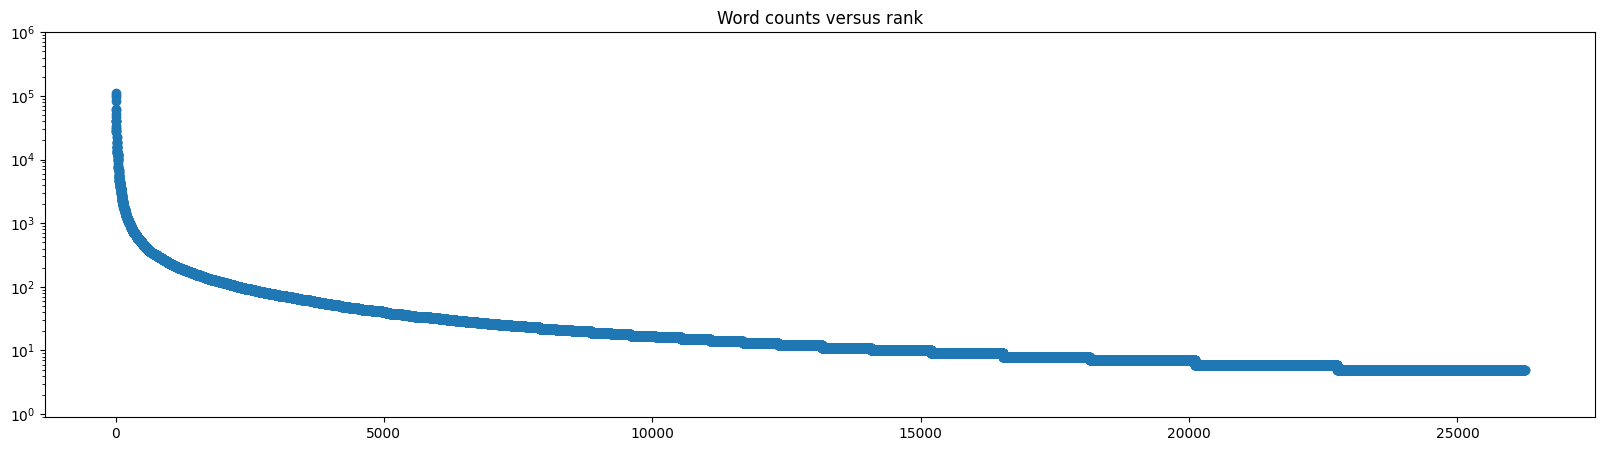

Vocabulary size: 26252
Part of the corpus by taking the "x" most frequent words:
5000 : 0.91
10000 : 0.95
15000 : 0.97
20000 : 0.99
25000 : 1.00


In [297]:
vocabulary_dict, vocabulary_word_counts = vocabulary(ng_train_text, count_threshold=5)
rank_counts = {w:[vocabulary_dict[w], vocabulary_word_counts[w]] for w in vocabulary_dict}
rank_counts_array = np.array(list(rank_counts.values()))

plt.figure(figsize=(20,5))
plt.title('Word counts versus rank')
plt.yscale('log')
plt.ylim(0, 1e6)
plt.scatter(rank_counts_array[:,0], rank_counts_array[:,1])
plt.show()

print('Vocabulary size: %i' % len(vocabulary_dict))
print('Part of the corpus by taking the "x" most frequent words:')
for i in range(5000, len(vocabulary_dict), 5000):
    print('%i : %.2f' % (i, np.sum(rank_counts_array[:i, 1]) / np.sum(rank_counts_array[:,1]) ))

<div class='alert alert-block alert-warning'>
            Question:</div>
            
What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

In [230]:
# A vocabulary size of around 10000 words seems reasonable. (The main reason is that 10000 covers 95% of the words)

# The 20NewsGroup dataset is not extremely large, containing around 18000 documents.
# A size of 10000 strikes a balance between capturing the diversity of language usage in the dataset,
# keeping the vocabulary manageable for computational resources, and ensuring that rare words are not overly represented.

Before creating the vocabulary, put aside some training data for a **validation set** !

In [231]:
from sklearn.model_selection import train_test_split
train_texts_splt, val_texts, train_labels_splt, val_labels = train_test_split(ng_train_text, ng_train_labels, test_size=.2)

In [232]:
# Get the vocabulary from 'train_texts_splt'
vocab_cut, word_counts_cut = vocabulary(train_texts_splt, count_threshold=5, voc_threshold=10000)

### I.3 Getting a representation: commonly used algorithms with ```gensim```

The idea here is to define a set of representations $({w_{i}})_{i=1}^{V}$, of predefined dimension $d$ (here, we will work with $d = 300$), for all the words $i$ of the vocabulary $V$ - then **train** these representations to match what we want.

#### Glove

The objective defined by Glove ([Pennington et al. (2014)](http://www.aclweb.org/anthology/D/D14/D14-1162.pdf)) is to learn from the vectors $w_{i}$ and $w_{k}$ so that their scalar product corresponds to the logarithm of their **Pointwise Mutual Information**:


$$ w_{i}^\top w_{k} = (PMI(w_{i}, w_{k}))$$


In the article, this objective is carefully justified by a reasoning about the operations one wants to perform with these vectors and the properties they should have - in particular, symmetry between rows and columns (see the article for more details).  
The final goal obtained is the following, where $M$ is the co-occurrence matrix:


$$\sum_{i, j=1}^{|V|} f\left(M_{ij}\right)
  \left(w_i^\top w_j + b_i + b_j - \log M_{ij}\right)^2$$
  

Here, $f$ is a *scaling* function that reduces the importance of the most frequent co-occurrence counts:


$$f(x)
\begin{cases}
(x/x_{\max})^{\alpha} & \textrm{if } x < x_{\max} \\
1 & \textrm{otherwise}
\end{cases}$$


Usually, we choose $\alpha=0.75$ and $x_{\max} = 100$, although these parameters may need to be changed depending on the data. The following code uses the ```gensim``` API to retrieve pre-trained representations (word embeddings take space - a long loading time is expected).

In [233]:
import gensim.downloader as api
loaded_glove_model = api.load("glove-wiki-gigaword-300")

We can extract the embedding matrix this way, and check its size:

In [234]:
loaded_glove_embeddings = loaded_glove_model.vectors
print(loaded_glove_embeddings.shape)

(400000, 300)


We can see that there are $400,000$ words represented, and that the embeddings are of size $300$. We define a function that returns, from the loaded model, the vocabulary and the embedding matrix according to the structures we used before. We add, here again, an unknown word "UNK" in case there are words in our data that are not part of the $400,000$ words represented here.

In [235]:
def get_glove_voc_and_embeddings(glove_model):
    voc = {word : index for word, index in enumerate(glove_model.index_to_key)}
    voc['UNK'] = len(voc)
    embeddings = glove_model.vectors
    return voc, embeddings

In [236]:
loaded_glove_voc, loaded_glove_embeddings = get_glove_voc_and_embeddings(loaded_glove_model)

To be able to merge these $400.000$ words with those that are in our vocabulary, we can create a specific function that will extract the representations of the words that are in our vocabulary and return a matrix of the appropriate size:

In [237]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    embeddings = np.zeros((len(input_voc),glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

This function takes as input the model loaded using the Gensim API, as well as a vocabulary we created ourselves, and returns the embedding matrix from the loaded model, for the words in our vocabulary and in the right order.


In [238]:
GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, vocab_cut)

In [239]:
print(GloveEmbeddings.shape)

(10001, 300)


#### Word2Vec


The basic skip-gram model estimates the probabilities of a pair of words $(i, j)$ to appear together in data:

$$P(j \mid i) = \frac{\exp(w_{i} c_{j})}{\sum_{j'\in V}\exp(w_{i} c_{j'})}$$


where $w_{i}$ is the lign vector (of the word) $i$ and $c_{j}$ is the column vector (of a context word) $j$. The objective is to minimize the following quantity:


$$ -\sum_{i=1}^{m} \sum_{k=1}^{|V|} \textbf{1}\{o_{i}=k\} \log \frac{\exp(w_{i} c_{k})}{\sum_{j=1}^{|V|} \exp(w_{i} c_{j})}$$


where $V$ is the vocabulary.
The inputs $w_{i}$ are the representations of the words, which are updated during training, and the output is an *one-hot* $o$ vector, which contains only one $1$ and $0$. For example, if `good` is the 47th word in the vocabulary, the output $o$ for an example or `good` is the word to predict will consist of $0$s everywhere except $1$ in the 47th position of the vector. `good` will be the word to predict when the input $w$ is a word in its context.
We therefore obtain this output with standard softmax - we add a bias term $b$ .


$$ o = \textbf{softmax}(w_{a}C + b)$$


If we use the set of representations for the whole vocabulary (the matrix $W$) as input, we get:


$$ O = \textbf{softmax}(WC + b)$$


and so we come back to the central idea of all our methods: we seek to obtain word representations from co-occurrence counts. Here, we train the parameters contained in $W$ and $C$, two matrices representing the words in reduced dimension (300) so that their scalar product is as close as possible to the co-occurrences observed in the data, using a maximum likelihood objective.

#### Skip-gram with negative sampling

The training of the skip-gram model implies to calculate a sum on the whole vocabulary, because of the **softmax**. As soon as the size of the vocabulary increases, it becomes impossible to compute. In order to make the calculations faster, we change the objective and use the method of *negative sampling* (or, very close to it, the *noise contrastive estimation*).


If we note $\mathcal{D}$ the data set and we note $\mathcal{D}'$ a set of pairs of words that are **not** in the data (and that in practice, we draw randomly), the objective is:


$$\sum_{i, j \in \mathcal{D}}-\log\sigma(w_{i}c_{j}) + \sum_{i, j \in \mathcal{D}'}\log\sigma(w_{i}c_{j})$$


where $\sigma$ is the sigmoid activation function $\frac{1}{1 + \exp(-x)}$.
A common practice is to generate pairs from $\mathcal{D}'$ in proportion to the frequencies of the words in the training data (the so-called unigram distribution):


$$P(w) = \frac{\textbf{T}(w)^{0.75}}{\sum_{w'\in V} \textbf{T}(w')}$$


Although different, this new objective function is a sufficient approximation of the previous one, and is based on the same principle. Much research has been done on this objective: for example, [Levy and Golberg 2014](http://papers.nips.cc/paper/5477-neural-word-embedding-as-implicit-matrix-factorization) shows that the objective calculates the PMI matrix shifted by a constant value. One can also see [Cotterell et al. 2017](https://aclanthology.coli.uni-saarland.de/papers/E17-2028/e17-2028) for an interpretation of the algorithm as a variant of PCA.

We will use the ```gensim``` library for its implementation of word2vec in python. We'll have to make a specific use of it, since we want to keep the same vocabulary as before: we'll first create the class, then get the vocabulary we generated above.

In [240]:
from gensim.models import Word2Vec

model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts_cut),
                 epochs=30)
model.build_vocab_from_freq(word_counts_cut)

The model takes as input a **list of list of words**: you need to tokenize the data beforehand.
In this case, you also need to indicate to the model the number of examples it should train with.
<div class='alert alert-block alert-info'>
            Code:</div>

In [241]:
ng_train_text_tokenized = []
ex = 0
for sent in train_texts_splt:
    tokenized_sent = []
    for word in sent:
        if word in vocab_cut:
            tokenized_word = word  # Use the actual word if it exists in the vocabulary
        else:
            tokenized_word = '<unknown>'  # Use '<unknown>' otherwise
        tokenized_sent.append(tokenized_word)
    ng_train_text_tokenized.append(tokenized_sent)
    ex += 1

In [242]:
model.train(ng_train_text_tokenized, total_examples=ex, epochs=30, report_delay=1)

(44233417, 74712570)

In [243]:
W2VEmbeddings = model.wv.vectors
print(W2VEmbeddings.shape)

(10001, 300)


### I.4 Application to classification:

We will now use these representations for classification.
The basic model will be constructed in two steps:
- A function to obtain vector representations of criticism, from text, vocabulary, and vector representations of words. Such a function (to be completed below) will associate to each word of a review its embeddings, and create the representation for the whole sentence by summing these embeddings.
- A classifier will take these representations as input and make a prediction. To achieve this, we can first use logistic regression ```LogisticRegression``` from ```scikit-learn```

<div class='alert alert-block alert-info'>
            Code:</div>

In [244]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise,
        like `np.mean`, `np.sum`, or `np.prod`.
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`
    """
    #
    # To complete !
    #
    # Initialize an empty array to store the representations
    # Initialize an empty array to store the representations
    # Initialize an empty array to store the representations
    # Initialize an empty array to store the representations
    representations = np.zeros((len(texts), embeddings.shape[1]))

    # Iterate through each sentence
    for i, sent in enumerate(texts):
        # Initialize an empty list to store the embeddings of words in the sentence
        word_embeddings = []

        # Iterate through each word in the sentence
        for word in sent:  # Split the sentence into words
            # Check if the word exists in the vocabulary
            if word in vocabulary:
                # Obtain the index of the word in the vocabulary
                word_index = vocabulary[word]
                # Obtain the embedding of the word
                word_embedding = embeddings[word_index]
                # Append the word embedding to the list
                word_embeddings.append(word_embedding)
            else:
                # If the word is not in the vocabulary, append "unknown"
                word_embeddings.append(embeddings[vocabulary['<unknown>']])

        # Check if the list of word embeddings is not empty
        if word_embeddings:
            # Apply the numpy function to combine the word embeddings
            sentence_representation = np_func(word_embeddings, axis=0)
        else:
            # If the list of word embeddings is empty, assign zeros
            sentence_representation = np.zeros(embeddings.shape[1])

        # Store the sentence representation in the representations array
        representations[i] = sentence_representation

    return representations


In [245]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

# Example with Glove Embeddings
train_rep = sentence_representations(train_texts_splt, vocab_cut, GloveEmbeddings)
val_rep = sentence_representations(val_texts, vocab_cut, GloveEmbeddings)
clf = LogisticRegression().fit(train_rep, train_labels_splt)
print(clf.score(val_rep, val_labels))

0.7349069450748978


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [246]:
scores = cross_val_score(clf, train_rep, train_labels_splt, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Score de classification: 0.7322667416944212 (std 0.0057575791773533495)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<div class='alert alert-block alert-warning'>
            Question:</div>

- Why can we expect that the results obtained with embeddings extracted from representations pre-trained with Gl0ve are much better than word2vec ? What would be a 'fair' way to compare Gl0ve with word2vec ?

In [247]:
train_rep = sentence_representations(train_texts_splt, vocab_cut, W2VEmbeddings)
clf = LogisticRegression().fit(train_rep, train_labels_splt)
print(clf.score(val_rep, val_labels))

0.17158420335905583


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [248]:
scores = cross_val_score(clf, train_rep, train_labels_splt, cv=5)
print('Score de classification: %s (std %s)' % (np.mean(scores), np.std(scores)))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Score de classification: 0.6317098280134663 (std 0.010278289289332321)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [249]:
# The reason we could expect better result with Glove is that it is pre-trained on a huge amount of data,
# so it could take into account semantic and syntactic words' relationships in order to get good representations.

# In fact, after a cross validation, we found that the highest score was 0.7385 for GLOve and 0.6297 for Word2Vec

# II - Text classification with Pytorch

The goal of this second part of the lab is double: an introduction to using Pytorch for treating textual data, and implementing neural classification models that we can apply to IMDB data - and then compare it to the models implemented previously.

In [250]:
import torch
import torch.nn as nn

### II.1 A (very small) introduction to pytorch

Pytorch Tensors are very similar to Numpy arrays, with the added benefit of being usable on GPU. For a short tutorial on various methods to create tensors of particular types, see [this link](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py).
The important things to note are that Tensors can be created empty, from lists, and it is very easy to convert a numpy array into a pytorch tensor, and inversely.

In [251]:
a = torch.LongTensor(5)
b = torch.LongTensor([5])

print(a)
print(b)

tensor([132183733853552,  95004158651072,              32,              32,
         94981959688409])
tensor([5])


In [252]:
a = torch.FloatTensor([2])
b = torch.FloatTensor([3])

print(a + b)

tensor([5.])


The main interest in us using Pytorch is the ```autograd``` package. ```torch.Tensor```objects have an attribute ```.requires_grad```; if set as True, it starts to track all operations on it. When you finish your computation, can call ```.backward()``` and all the gradients are computed automatically (and stored in the ```.grad``` attribute).

One way to easily cut a tensor from the computational once it is not needed anymore is to use ```.detach()```.
More info on automatic differentiation in pytorch on [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py).

In [253]:
x = torch.tensor(1., requires_grad=True)
w = torch.tensor(2., requires_grad=True)
b = torch.tensor(3., requires_grad=True)

# Build a computational graph.
y = w * x + b    # y = 2 * x + 3

# Compute gradients.
y.backward()

# Print out the gradients.
print(x.grad)    # x.grad = 2
print(w.grad)    # w.grad = 1
print(b.grad)    # b.grad = 1

tensor(2.)
tensor(1.)
tensor(1.)


In [254]:
x = torch.randn(10, 3)
y = torch.randn(10, 2)

# Build a fully connected layer.
linear = nn.Linear(3, 2)
for name, p in linear.named_parameters():
    print(name)
    print(p)

# Build loss function - Mean Square Error
criterion = nn.MSELoss()

# Forward pass.
pred = linear(x)

# Compute loss.
loss = criterion(pred, y)
print('Initial loss: ', loss.item())

# Backward pass.
loss.backward()

# Print out the gradients.
print ('dL/dw: ', linear.weight.grad)
print ('dL/db: ', linear.bias.grad)

weight
Parameter containing:
tensor([[ 0.2543,  0.5567,  0.1159],
        [-0.4769, -0.1103, -0.0782]], requires_grad=True)
bias
Parameter containing:
tensor([-0.1849,  0.5212], requires_grad=True)
Initial loss:  0.8719738721847534
dL/dw:  tensor([[ 0.0692,  0.3869, -0.0085],
        [-0.4260,  0.5294, -0.2124]])
dL/db:  tensor([-0.2208,  0.4637])


In [255]:
# You can perform gradient descent manually, with an in-place update ...
linear.weight.data.sub_(0.01 * linear.weight.grad.data)
linear.bias.data.sub_(0.01 * linear.bias.grad.data)

# Print out the loss after 1-step gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after one update: ', loss.item())

Loss after one update:  0.8627789616584778


In [256]:
# Use the optim package to define an Optimizer that will update the weights of the model.
optimizer = torch.optim.SGD(linear.parameters(), lr=0.01)

# By default, gradients are accumulated in buffers( i.e, not overwritten) whenever .backward()
# is called. Before the backward pass, we need to use the optimizer object to zero all of the
# gradients.
optimizer.zero_grad()
loss.backward()

# Calling the step function on an Optimizer makes an update to its parameters
optimizer.step()

# Print out the loss after the second step of gradient descent.
pred = linear(x)
loss = criterion(pred, y)
print('Loss after two updates: ', loss.item())

Loss after two updates:  0.8538099527359009


### II.2 Tools for data processing

```torch.utils.data.Dataset``` is an abstract class representing a dataset. Your custom dataset should inherit ```Dataset``` and override the following methods:
- ```__len__``` so that ```len(dataset)``` returns the size of the dataset.
- ```__getitem__``` to support the indexing such that ```dataset[i]``` can be used to get the i-th sample

Here is a toy example:

In [257]:
toy_corpus = ['I walked down down the boulevard',
              'I walked down the avenue',
              'I ran down the boulevard',
              'I walk down the city',
              'I walk down the the avenue']

toy_categories = [0, 0, 1, 0, 0]

In [258]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    # A pytorch dataset class for holding data for a text classification task.
    def __init__(self, data, categories):
        # Upon creating the Dataset object, store the data in an attribute
        # Split the text data and labels from each other
        self.X, self.Y = [], []
        for x, y in zip(data, categories):
            # We will propably need to preprocess the data - have it done in a separate method
            # We do it here because we might need corpus-wide info to do the preprocessing
            # For example, cutting all examples to the same length
            self.X.append(self.preprocess(x))
            self.Y.append(y)

    # Method allowing you to preprocess data
    def preprocess(self, text):
        text_pp = text.lower().strip()
        return text_pp

    # Overriding the method __len__ so that len(CustomDatasetName) returns the number of data samples
    def __len__(self):
        return len(self.Y)

    # Overriding the method __getitem__ so that CustomDatasetName[i] returns the i-th sample of the dataset
    def __getitem__(self, idx):
           return self.X[idx], self.Y[idx]

In [259]:
toy_dataset = CustomDataset(toy_corpus, toy_categories)

In [260]:
print(len(toy_dataset))
for i in range(len(toy_dataset)):
    print(toy_dataset[i])

5
('i walked down down the boulevard', 0)
('i walked down the avenue', 0)
('i ran down the boulevard', 1)
('i walk down the city', 0)
('i walk down the the avenue', 0)


```torch.utils.data.DataLoader``` is what we call an iterator, which provides very useful features:
- Batching the data
- Shuffling the data
- Load the data in parallel using multiprocessing workers.
and can be created very simply from a ```Dataset```. Continuing on our simple example:

In [261]:
toy_dataloader = DataLoader(toy_dataset, batch_size = 2, shuffle = True)

In [262]:
for e in range(3):
    print("Epoch:" + str(e))
    for x, y in toy_dataloader:
        print("Batch: " + str(x) + "; labels: " + str(y))

Epoch:0
Batch: ('i walked down down the boulevard', 'i walk down the city'); labels: tensor([0, 0])
Batch: ('i walked down the avenue', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walk down the the avenue',); labels: tensor([0])
Epoch:1
Batch: ('i walked down the avenue', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walk down the the avenue', 'i walked down down the boulevard'); labels: tensor([0, 0])
Batch: ('i walk down the city',); labels: tensor([0])
Epoch:2
Batch: ('i walk down the city', 'i walk down the the avenue'); labels: tensor([0, 0])
Batch: ('i walked down the avenue', 'i ran down the boulevard'); labels: tensor([0, 1])
Batch: ('i walked down down the boulevard',); labels: tensor([0])


#### Data processing of a text dataset

Now, we would like to apply what we saw to our case, and **create a specific class** ```TextClassificationDataset``` **inheriting** ```Dataset``` that will:
- Create a vocabulary from the data (same as above)
- Preprocess the data using this vocabulary, adding whatever we need for our pytorch model
- Have a ```__getitem__``` method that allows us to use the class with a ```Dataloader``` to easily build batches.

In [263]:
from torch.nn import functional as F
import random

from torch.nn.utils.rnn import pad_sequence

We will now need to create a ```TextClassificationDataset``` and a ```Dataloader``` for the training data, the validation data, and the testing data.

We will implement our ```TextClassificationDataset``` class, that we will build from:
- A list of documents: ```data```
- A list of the corresponding categories: ```categories```
We will add three optional arguments:
- First, a way to input a vocabulary (so that we can re-use the training vocabulary on the validation and training ```TextClassificationDataset```). By default, the value of the argument is ```None```.
- In order to work with batches, we will need to have sequences of the same size. That can be done via **padding** but we will still need to limit the size of documents (to avoid having batches of huge sequences that are mostly empty because of one very long documents) to a ```max_length```. Let's put it to 100 by default.
- Lastly, a ```min_freq``` that indicates how many times a word must appear to be taken in the vocabulary.

The idea behind **padding** is to transform a list of pytorch tensors (of maybe different length) into a two dimensional tensor - which we can see as a batch. The size of the first dimension is the one of the longest tensor - and other are **padded** with a chosen symbol: here, we choose 0.

**Careful: the symbol 0 is then reserved for padding. That means the vocabulary must begin at 1 !**

In [264]:
tensor_1 = torch.LongTensor([1, 4, 5])
tensor_2 = torch.LongTensor([2])
tensor_3 = torch.LongTensor([6, 7])

In [265]:
tensor_padded = pad_sequence([tensor_1, tensor_2, tensor_3], batch_first=True, padding_value = 0)
print(tensor_padded)

tensor([[1, 4, 5],
        [2, 0, 0],
        [6, 7, 0]])


<div class='alert alert-block alert-info'>
            Code:</div>

In [266]:
class TextClassificationDataset(Dataset):
    def __init__(self, data, categories, vocab = None, max_length = 100, voc_threshold = 5):
        # Get all the data in a list
        self.data = data
        # Set the maximum length we will keep for the sequences
        self.max_length = max_length
        # Allow to import a vocabulary (for valid/test datasets, that will use the training vocabulary)
        if vocab is not None:
            self.word2idx, self.idx2word = vocab
        else:
            # If no vocabulary imported, build it (and reverse)
            self.word2idx, self.idx2word = self.build_vocab(self.data, voc_threshold)

        # We then need to tokenize the data ..
        tokenized_data = [word_tokenize(str(f)) for f in self.data]
        # Transform words into lists of indexes ... (use the .get() method to redirect unknown words to the UNK token)
        indexed_data = [[self.word2idx.get(token,self.word2idx['<unknown>']) for token in el ] for el in tokenized_data]
        # And transform this list of lists into a list of Pytorch LongTensors
        tensor_data = [torch.LongTensor(el) for el in indexed_data]
        # And the categories into a FloatTensor
        tensor_y = torch.FloatTensor(categories)
        # To finally cut it when it's above the maximum length
        cut_tensor_data = [tsr[:self.max_length] if self.max_length < tsr.shape[0] else tsr for tsr in tensor_data ]

        # Now, we need to use the pad_sequence function to have the whole dataset represented as one tensor,
        # containing sequences of the same length. We choose the padding_value to be 0, the we want the
        # batch dimension to be the first dimension
        self.tensor_data = pad_sequence(cut_tensor_data, batch_first=True, padding_value = 0)
        self.tensor_y = tensor_y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # The iterator just gets one particular example with its category
        # The dataloader will take care of the shuffling and batching
        if torch.is_tensor(idx):
            idx = idx.tolist()
        return self.tensor_data[idx], self.tensor_y[idx]

    def build_vocab(self, corpus, voc_threshold):
        """
        Same as in the previously: we want to output word_index, a dictionary containing words
        and their corresponding indexes as {word : indexes}
        But we also want the reverse, which is a dictionary {indexes: word}
        """
        # To complete
        # Careful, here we need to shift the indexes by 1 to put the padding symbol to 0
        word_counts = {}
        words = []
        for text in corpus:
            words += list(word_tokenize(str(text))) # list of all words
        for word in words:
            if word not in word_counts.keys():
                word_counts[word] = 1
            else:
                word_counts[word] += 1
        #sorted()
        word_counts = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1], reverse=True)}
        filtered_word_counts={}
        for k,v in word_counts.items():
            if v>=voc_threshold :
                filtered_word_counts[k] = v

        word_index, idx_word = {}, {}
        voc = list(filtered_word_counts.keys())
        word_index = dict(zip(voc, range(1,len(voc)+1)))
        word_index['<unknown>'] = len(voc)+1
        idx_word = {v:k for k,v in word_index.items()}
        return word_index, idx_word

    def get_vocab(self):
        # A simple way to get the training vocab when building the valid/test
        return self.word2idx, self.idx2word

In [267]:
training_dataset = TextClassificationDataset(train_texts_splt, train_labels_splt)
training_word2idx, training_idx2word = training_dataset.get_vocab()

In [268]:
valid_dataset = TextClassificationDataset(val_texts, val_labels, (training_word2idx, training_idx2word))
test_dataset = TextClassificationDataset(ng_test_text, ng_test_labels, (training_word2idx, training_idx2word))

In [269]:
training_dataloader = DataLoader(training_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 25)
test_dataloader = DataLoader(test_dataset, batch_size = 25)

In [270]:
print(valid_dataset[1])

(tensor([   23,   179,     1,     2,    39,     1,     2,   101,     1,     2,
          191,     1,     2, 22391,     1,     2,  1654,     1,     2,  2227,
            1,     2,   760,     1,     2,    10,     1,     2,  6374,     1,
            2, 22216,     1,     2,   710,     1,     2,    15,     1,     2,
           38,     1,     2,   409,     1,     2, 18284,     1,     2,    11,
            1,     2, 22391,     1,     2,    10,     1,     2, 22391,     1,
            2,   240,     1,     2,   183,     1,     2,   139,     1,     2,
         1766,     1,     2,    20,     1,     2,   862,     1,     2,     1,
            5,     1,     2,    77,     1,     2,    18,     1,     2,   859,
            1,     2,    65,     1,     2,     1,   136,     1,     2, 22391]), tensor(0.))


In [271]:
example_batch = next(iter(training_dataloader))
print(example_batch[0].size())
print(example_batch[1].size())

torch.Size([200, 100])
torch.Size([200])


### II.3 A simple averaging model

Now, we will implement in Pytorch what we did in the previous TP: a simple averaging model. For each model we will implement, we need to create a class which inherits from ```nn.Module``` and redifine the ```__init__``` method as well as the ```forward``` method.

In [272]:
import torch.optim as optim

<div class='alert alert-block alert-info'>
            Code:</div>

In [273]:
class AveragingModel(nn.Module):

    def __init__(self, embedding_dim, vocabulary_size, categories_num):
        super().__init__()
        # Create an embedding object. Be careful to padding - you need to increase the vocabulary size by one !
        # Look into the arguments of the nn.Embedding class
        self.embeddings = nn.Embedding(vocabulary_size+1,embedding_dim, 0)
        # Create a linear layer that will transform the mean of the embeddings into classification scores
        self.linear = nn.Linear(embedding_dim, categories_num)

    def forward(self, inputs):
        # Remember: the inputs are written as Batch_size * seq_length * embedding_dim
        # First, take the mean of the embeddings of the document
        x = torch.mean(self.embeddings(inputs), dim=1)
        o = self.linear(x).squeeze()
        return o

In [274]:
model = AveragingModel(300, len(training_word2idx), max(ng_train_labels)+1)
# Create an optimizer
opt = optim.Adam(model.parameters(), lr=0.0025, betas=(0.9, 0.999))
# The criterion is a cross entropy loss based on logits,
# meaning that the softmax is integrated into the criterion
criterion = nn.CrossEntropyLoss()

<div class='alert alert-block alert-info'>
            Code:</div>

In [275]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, (x, y) in enumerate(dataloader):
        opt.zero_grad()
        # (1) Forward
        pred = model(x)
        # (2) Compute diff
        loss = criterion(pred, y.long())
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()
        losses.append(loss.item())
        # Count the number of correct predictions in the batch - here, you'll need to use the softmax
        pred_labels = torch.argmax(pred, dim=1)
        num_corrects = torch.sum(pred_labels == y)
        acc = 100.0 * num_corrects/len(y)

        if (i%20 == 0):
            print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
    return losses

<div class='alert alert-block alert-info'>
            Code:</div>

In [276]:
# Same for the evaluation ! We don't need the optimizer here.

def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(evalloader):
            pred = model(x)
            loss = criterion(pred,y.long())
            pred_labels = torch.argmax(pred, dim=1)
            num_corrects = torch.sum(pred_labels == y)
            acc = 100.0 * num_corrects/len(y)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

In [277]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary.

def experiment(model, opt, criterion, num_epochs = 10, early_stopping = True):
    train_losses = []
    if early_stopping:
        best_valid_loss = 10.
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break
    test_loss, test_acc = eval_model(model, criterion, test_dataloader)
    print("Epoch " + str(e+1) + " : Test loss = " + str(test_loss) + "; Test acc = " + str(test_acc))
    return train_losses

In [278]:
train_losses = experiment(model, opt, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 1.8206924200057983; training acc = 18.5
Batch 20 : training loss = 1.7123403549194336; training acc = 28.5
Batch 40 : training loss = 1.6880203485488892; training acc = 25.5
Epoch 1 : Validation loss = 1.6784362578659915; Validation acc = 27.475655416424356
Epoch 2:
Batch 0 : training loss = 1.6773219108581543; training acc = 23.0
Batch 20 : training loss = 1.640017032623291; training acc = 35.0
Batch 40 : training loss = 1.6043833494186401; training acc = 29.5
Epoch 2 : Validation loss = 1.6306824108188072; Validation acc = 28.014981259120983
Epoch 3:
Batch 0 : training loss = 1.5802044868469238; training acc = 33.0
Batch 20 : training loss = 1.520505428314209; training acc = 43.5
Batch 40 : training loss = 1.5344491004943848; training acc = 37.0
Epoch 3 : Validation loss = 1.563508195823498; Validation acc = 36.14981271979514
Epoch 4:
Batch 0 : training loss = 1.4983367919921875; training acc = 46.5
Batch 20 : training loss = 1

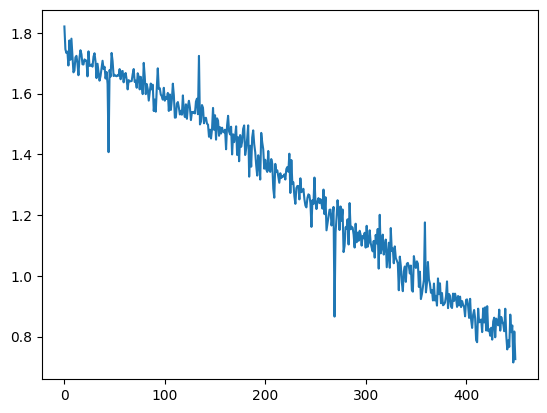

In [279]:
import matplotlib.pyplot as plt
plt.plot(train_losses)

### II.4 Initializing with pre-trained embeddings:

Now, we would like to integrate pre-trained word embeddings into our model ! However, we need to not forget to add a vector for the padding symbol.

In [280]:
def get_glove_adapted_embeddings(glove_model, input_voc):
    keys = {i: glove_model.key_to_index.get(w, None) for w, i in input_voc.items()}
    index_dict = {i: key for i, key in keys.items() if key is not None}
    # Important change here: add one supplementary word for padding
    embeddings = np.zeros((len(input_voc)+1,glove_model.vectors.shape[1]))
    for i, ind in index_dict.items():
        embeddings[i] = glove_model.vectors[ind]
    return embeddings

GloveEmbeddings = get_glove_adapted_embeddings(loaded_glove_model, training_word2idx)

In [281]:
print(GloveEmbeddings.shape)

(22392, 300)


Here, implement a ```PretrainedAveragingModel``` very similar to the previous model, using the ```nn.Embedding``` method ```from_pretrained()``` to initialize the embeddings from a numpy array. Use the ```requires_grad_``` method to specify if the model must fine-tune the embeddings or not !
<div class='alert alert-block alert-info'>
            Code:</div>

In [282]:
class PretrainedAveragingModel(nn.Module):
    # To complete !
    def __init__(self, embedding_dim,categories_num, pretrained_embeddings, fine_tune=False):
        super().__init__()
        vocab_size, emb_dim = pretrained_embeddings.shape
        self.embeddings = nn.Embedding.from_pretrained(torch.from_numpy(pretrained_embeddings.numpy()).float(), freeze=not fine_tune)
        if not fine_tune:
            self.embeddings.requires_grad_(False)
        self.linear = nn.Linear(embedding_dim, categories_num)

    def forward(self, inputs):
        x = torch.mean(self.embeddings(inputs), dim=1)
        o = self.linear(x).squeeze()
        return o

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
- What are the results **with and without fine-tuning of embeddings imported from GloVe** ? Explain them.
- Use the ```sklearn``` function from the previous lab to analyze these results in more details.

In [283]:
# The results with fine-tuned embeddings imported from GloVe are better than those without which is totally obvious.

In [284]:
model_pre_trained = PretrainedAveragingModel(300, max(ng_train_labels)+1, torch.FloatTensor(GloveEmbeddings), True)
opt_pre_trained = optim.Adam(model_pre_trained.parameters(), lr=0.0025, betas=(0.9, 0.999))

In [285]:
train_losses = experiment(model_pre_trained, opt_pre_trained, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 1.8297065496444702; training acc = 21.5
Batch 20 : training loss = 1.7583600282669067; training acc = 27.0
Batch 40 : training loss = 1.722973346710205; training acc = 19.5
Epoch 1 : Validation loss = 1.6801982274216212; Validation acc = 26.08239698945806
Epoch 2:
Batch 0 : training loss = 1.6882481575012207; training acc = 31.0
Batch 20 : training loss = 1.6763720512390137; training acc = 30.0
Batch 40 : training loss = 1.5715305805206299; training acc = 41.5
Epoch 2 : Validation loss = 1.6265623087293646; Validation acc = 35.1161048546266
Epoch 3:
Batch 0 : training loss = 1.5702600479125977; training acc = 39.0
Batch 20 : training loss = 1.6522821187973022; training acc = 35.5
Batch 40 : training loss = 1.5200749635696411; training acc = 50.0
Epoch 3 : Validation loss = 1.5162477613834853; Validation acc = 47.08614229352287
Epoch 4:
Batch 0 : training loss = 1.4949783086776733; training acc = 56.0
Batch 20 : training loss = 1.

In [286]:
model_pre_trained_light = PretrainedAveragingModel(300, max(ng_train_labels)+1, torch.FloatTensor(GloveEmbeddings), False)
opt_pre_trained_light = optim.Adam(model_pre_trained_light.parameters(), lr=0.0025, betas=(0.9, 0.999))

In [287]:
train_losses = experiment(model_pre_trained_light, opt_pre_trained_light, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 1.7727491855621338; training acc = 22.5
Batch 20 : training loss = 1.7540202140808105; training acc = 19.5
Batch 40 : training loss = 1.7052923440933228; training acc = 26.0
Epoch 1 : Validation loss = 1.699343546052997; Validation acc = 25.63295878721087
Epoch 2:
Batch 0 : training loss = 1.6996650695800781; training acc = 26.0
Batch 20 : training loss = 1.6671940088272095; training acc = 33.0
Batch 40 : training loss = 1.6837087869644165; training acc = 28.5
Epoch 2 : Validation loss = 1.6996066449733263; Validation acc = 25.408239686087278
Early stopping.
Epoch 2 : Test loss = 1.6998940311601138; Test acc = 26.14173860517378


In [298]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model with fine-tuned embeddings
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())
    return all_preds, all_labels

# Evaluate the model with fine-tuned embeddings
preds_ft, labels_ft = evaluate_model(model_pre_trained, test_dataloader)

# Evaluate the model without fine-tuned embeddings
preds_no_ft, labels_no_ft = evaluate_model(model_pre_trained_light, test_dataloader)

# Calculate metrics
def calculate_metrics(preds, labels):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')
    return accuracy, precision, recall, f1

# Metrics for fine-tuned embeddings
accuracy_ft, precision_ft, recall_ft, f1_ft = calculate_metrics(preds_ft, labels_ft)

# Metrics for non-fine-tuned embeddings
accuracy_no_ft, precision_no_ft, recall_no_ft, f1_no_ft = calculate_metrics(preds_no_ft, labels_no_ft)

# Print the results
print("Metrics with fine-tuned embeddings:")
print("Accuracy:", accuracy_ft)
print("Precision:", precision_ft)
print("Recall:", recall_ft)
print("F1-score:", f1_ft)

print("\nMetrics without fine-tuned embeddings:")
print("Accuracy:", accuracy_no_ft)
print("Precision:", precision_no_ft)
print("Recall:", recall_no_ft)
print("F1-score:", f1_no_ft)

Metrics with fine-tuned embeddings:
Accuracy: 0.6598332649993166
Precision: 0.6622537558336493
Recall: 0.6598332649993166
F1-score: 0.6590120658299106

Metrics without fine-tuned embeddings:
Accuracy: 0.2614459477928113
Precision: 0.17307282421472742
Recall: 0.2614459477928113
F1-score: 0.1087631300229278


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### II.5 With a LSTM model

In [288]:
# Create a toy example of LSTM:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# LSTMs expect inputs having 3 dimensions:
# - The first dimension is the temporal dimension, along which we (in our case) have the different words
# - The second dimension is the batch dimension, along which we stack the independant batches
# - The third dimension is the feature dimension, along which are the features of the vector representing the words

# In our toy case, we have inputs and outputs containing 3 features (third dimension !)
# We created a sequence of 5 different inputs (first dimension !)
# We don't use batch (the second dimension will have one lement)

# We need an initial hidden state, of the right sizes for dimension 2/3, but with only one temporal element:
# Here, it is:
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
# Why do we create a tuple of two tensors ? Because we use LSTMs: remember that they use two sets of weights,
# and two hidden states (Hidden state, and Cell state).
# If you don't remember, read: https://colah.github.io/posts/2015-08-Understanding-LSTMs/
# If we used a classic RNN, we would simply have:
# hidden = torch.randn(1, 1, 3)

# The naive way of applying a lstm to inputs is to apply it one step at a time, and loop through the sequence
for i in inputs:
    # After each step, hidden contains the hidden states (remember, it's a tuple of two states).
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# Alternatively, we can do the entire sequence all at once.
# The first value returned by LSTM is all of the Hidden states throughout the sequence.
# The second is just the most recent Hidden state and Cell state (you can compare the values)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence, for each temporal step
# "hidden" will allow you to continue the sequence and backpropagate later, with another sequence
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # Re-initialize
out, hidden = lstm(inputs, hidden)
print(out)
print(hidden)

tensor([[[ 0.0761,  0.6987, -0.1334]],

        [[ 0.1773,  0.4998, -0.2067]],

        [[ 0.2704,  0.6362, -0.2354]],

        [[ 0.2769,  0.3937, -0.2018]],

        [[ 0.2911,  0.6535, -0.2378]]], grad_fn=<MkldnnRnnLayerBackward0>)
(tensor([[[ 0.2911,  0.6535, -0.2378]]], grad_fn=<StackBackward0>), tensor([[[ 0.5806,  1.4334, -0.7348]]], grad_fn=<StackBackward0>))


### Creating our own LSTM Model

We'll implement now a LSTM model, taking the same inputs and also outputing a score for the sentence.

<div class='alert alert-block alert-info'>
            Code:</div>

In [289]:
# Models are usually implemented as custom nn.Module subclass
# We need to redefine the __init__ method, which creates the object
# We also need to redefine the forward method, which transform the input into outputs

class LSTMModel(nn.Module):
    def __init__(self, embedding_dim, vocabulary_size, hidden_dim, categories_num,
          embeddings=None, fine_tuning=False):
      super().__init__()
      self.hidden_dim = hidden_dim

      if embeddings is not None :
        self.embeddings = nn.Embedding.from_pretrained(embeddings=torch.Tensor(embeddings), freeze=not fine_tuning)
        embedding_dim=embeddings.shape[1]
      else :
        self.embeddings = nn.Embedding(
            vocabulary_size+1, embedding_dim
        )
      self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
      self.linear = nn.Linear(hidden_dim, categories_num)

    def forward(self, inputs):
      embeddings = self.embeddings(inputs)
      _, (last_hidden_state, _) = self.lstm(embeddings)
      linear_out = torch.squeeze(self.linear(last_hidden_state))
      return linear_out


In [290]:
recurrent_model = LSTMModel(300, len(training_word2idx), 100, max(ng_train_labels)+1)
opt_recurrent = optim.Adam(recurrent_model.parameters(), lr=0.0025, betas=(0.9, 0.999))

In [291]:
train_losses = experiment(recurrent_model, opt_recurrent, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 1.7851272821426392; training acc = 20.0
Batch 20 : training loss = 1.6890110969543457; training acc = 26.0
Batch 40 : training loss = 1.6881763935089111; training acc = 29.0
Epoch 1 : Validation loss = 1.6896714106034696; Validation acc = 28.77902620294121
Epoch 2:
Batch 0 : training loss = 1.6197307109832764; training acc = 38.0
Batch 20 : training loss = 1.6524139642715454; training acc = 29.0
Batch 40 : training loss = 1.5765178203582764; training acc = 42.5
Epoch 2 : Validation loss = 1.6074986055995641; Validation acc = 33.12359550561798
Epoch 3:
Batch 0 : training loss = 1.5305204391479492; training acc = 37.0
Batch 20 : training loss = 1.4508576393127441; training acc = 45.0
Batch 40 : training loss = 1.4541969299316406; training acc = 42.5
Epoch 3 : Validation loss = 1.4961852437994454; Validation acc = 37.662921348314605
Epoch 4:
Batch 0 : training loss = 1.2258906364440918; training acc = 55.5
Batch 20 : training loss =

In [292]:
recurrent_model = LSTMModel(300, len(training_word2idx), 100, max(ng_train_labels)+1, embeddings=GloveEmbeddings, fine_tuning=True)
opt_recurrent = optim.Adam(recurrent_model.parameters(), lr=0.0025, betas=(0.9, 0.999))
train_losses = experiment(recurrent_model, opt_recurrent, criterion)

Beginning training...
Epoch 1:
Batch 0 : training loss = 1.8150432109832764; training acc = 7.5
Batch 20 : training loss = 1.7585186958312988; training acc = 26.0
Batch 40 : training loss = 1.7031755447387695; training acc = 29.5
Epoch 1 : Validation loss = 1.6984738888365498; Validation acc = 26.08239698945806
Epoch 2:
Batch 0 : training loss = 1.705553412437439; training acc = 32.0
Batch 20 : training loss = 1.7263963222503662; training acc = 25.0
Batch 40 : training loss = 1.6449263095855713; training acc = 32.5
Epoch 2 : Validation loss = 1.6445397285932906; Validation acc = 31.4007490350959
Epoch 3:
Batch 0 : training loss = 1.6122491359710693; training acc = 36.0
Batch 20 : training loss = 1.3970839977264404; training acc = 45.5
Batch 40 : training loss = 1.2531336545944214; training acc = 47.0
Epoch 3 : Validation loss = 1.3428182695688826; Validation acc = 45.60299622610714
Epoch 4:
Batch 0 : training loss = 1.0077489614486694; training acc = 66.0
Batch 20 : training loss = 0.8

<div class='alert alert-block alert-warning'>
            Questions:</div>
            
- What do you see with a simple application of LSTMs ?
- What do you think may be happening in this case ?

In [293]:
# Regarding LSTMs results, we can notice that the pretaining with fine-tuning has a better results (acc = 61.259).
# than the one with no pretraining (acc = 46.346).

# When we use the LSTMs, we think that there is two cases that need to be studied:

#               - Reducing the number of documents: In case of reducing the number of documents,
#                 the models may not be able to learn meaningful patterns in the dataset, leading to lower performance.

#               - Varying the size of the vocabulary: When we reduce the vocabulary size, the performance of the
#                 models may decrease due to the lack of important information in the text.